In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


https://www.sciencedirect.com/science/article/pii/S1877050920316318
https://ieeexplore.ieee.org/abstract/document/8289904
https://www.sciencedirect.com/science/article/pii/S1877050922009516



In [2]:
houses = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# EDA


### Understanding the data composition


In [3]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

The data seems to be quite small hence, using cross validation would limit possibility of overfitting.

As seen above the data columns can be split into 3 categories:

1. `Complete 1460 non-null values`
2. `Few missing values`
3. `> 50% missing values`

In [4]:
# Checking for columns with missing values
missing_values = houses.isnull().sum()

columns_with_missing_values = houses[missing_values[missing_values > 0].index]

#print the first 5 values of columns with missing values and then the qunatity miising from each column
print(columns_with_missing_values.head(), missing_values[missing_values > 0])


   LotFrontage Alley MasVnrType  MasVnrArea BsmtQual BsmtCond BsmtExposure  \
0         65.0   NaN    BrkFace       196.0       Gd       TA           No   
1         80.0   NaN        NaN         0.0       Gd       TA           Gd   
2         68.0   NaN    BrkFace       162.0       Gd       TA           Mn   
3         60.0   NaN        NaN         0.0       TA       Gd           No   
4         84.0   NaN    BrkFace       350.0       Gd       TA           Av   

  BsmtFinType1 BsmtFinType2 Electrical FireplaceQu GarageType  GarageYrBlt  \
0          GLQ          Unf      SBrkr         NaN     Attchd       2003.0   
1          ALQ          Unf      SBrkr          TA     Attchd       1976.0   
2          GLQ          Unf      SBrkr          TA     Attchd       2001.0   
3          ALQ          Unf      SBrkr          Gd     Detchd       1998.0   
4          GLQ          Unf      SBrkr          TA     Attchd       2000.0   

  GarageFinish GarageQual GarageCond PoolQC Fence MiscFeature 

for the numerical columns GarageYrBlt, LotForntage and MasVnrArea, a null value represents the inexistence of the object hence can be imputed with 0, not the mean nor the median.

In addition, the categorical columns will also be replaced by None as the object itself does not exist

We will use a pipeline later on to do all of the following but for a more comprehesive EDA we will apply it to a df.

In [5]:
houses_cleaned = houses.copy(deep=True)

# Impute numerical columns with the median
houses_cleaned['LotFrontage'].fillna(0)
houses_cleaned['MasVnrArea'].fillna(0)
houses_cleaned['GarageYrBlt'].fillna(0)

# Impute categorical columns with 'None'
categorical_cols_with_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                              'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 
                              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
                              'PoolQC', 'Fence', 'MiscFeature']

for col in categorical_cols_with_none:
    houses_cleaned[col].fillna('None')

# For demonstration, showing the imputed DataFrame's first few rows
houses_cleaned.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Alley

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

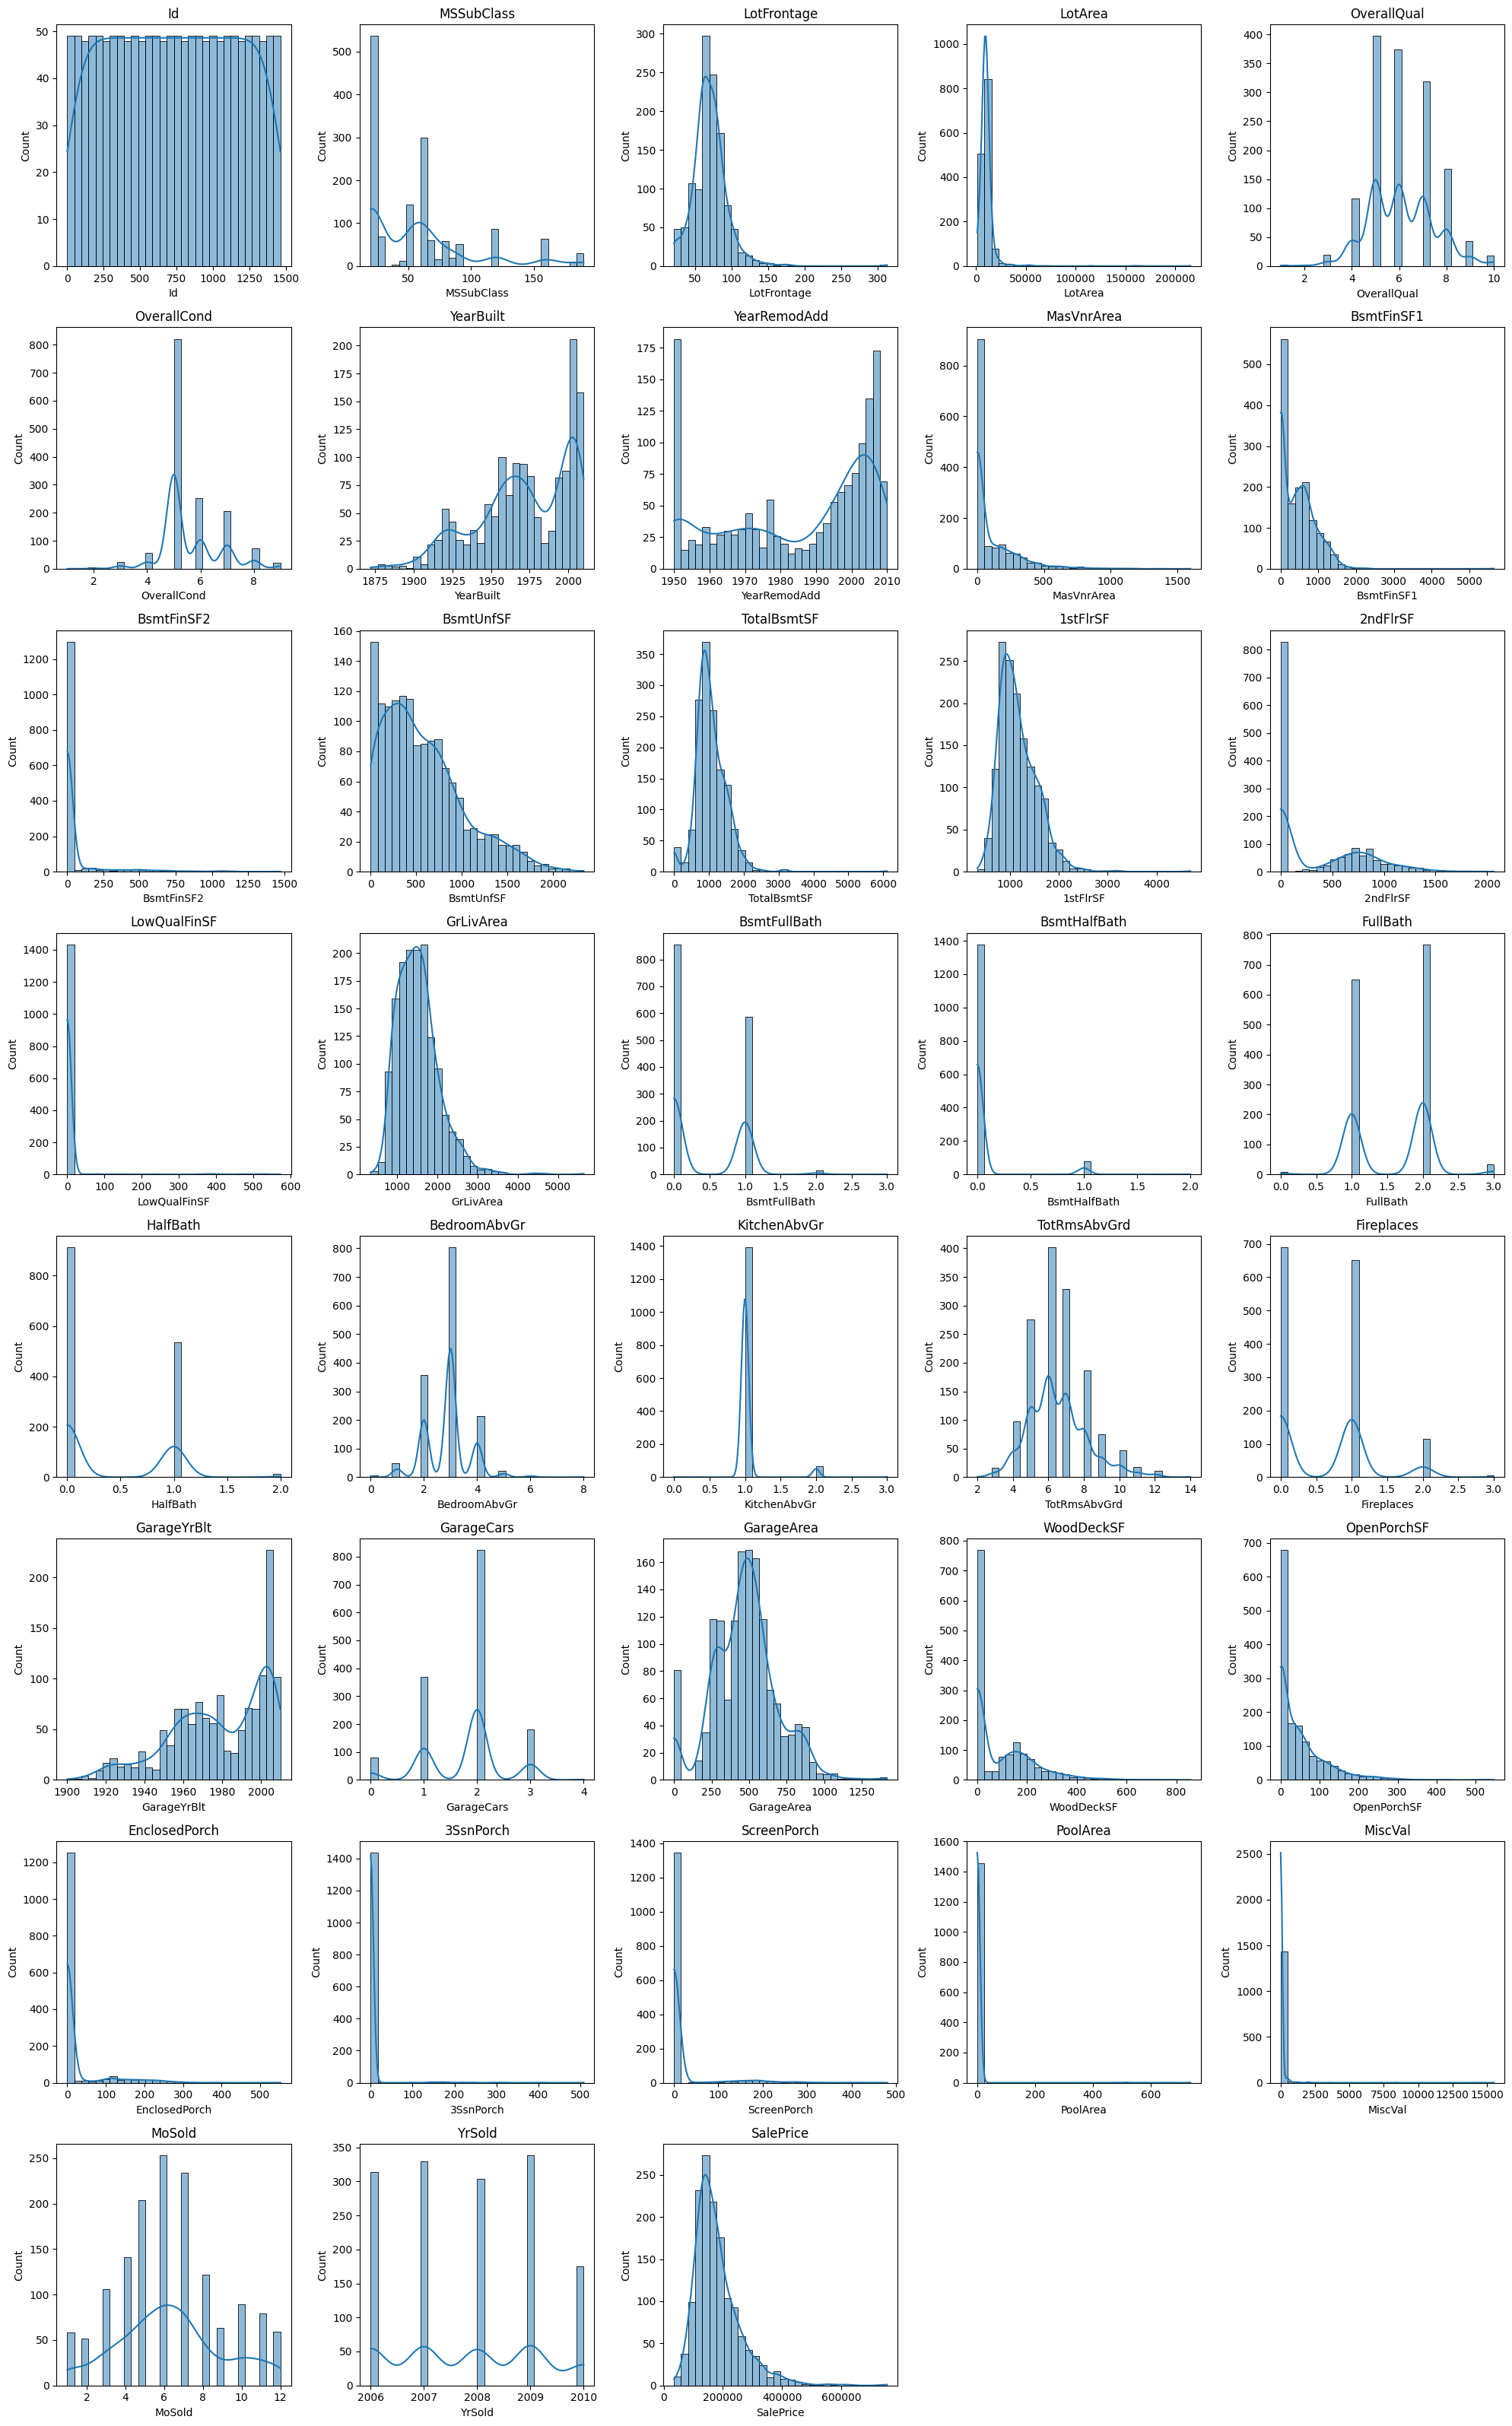

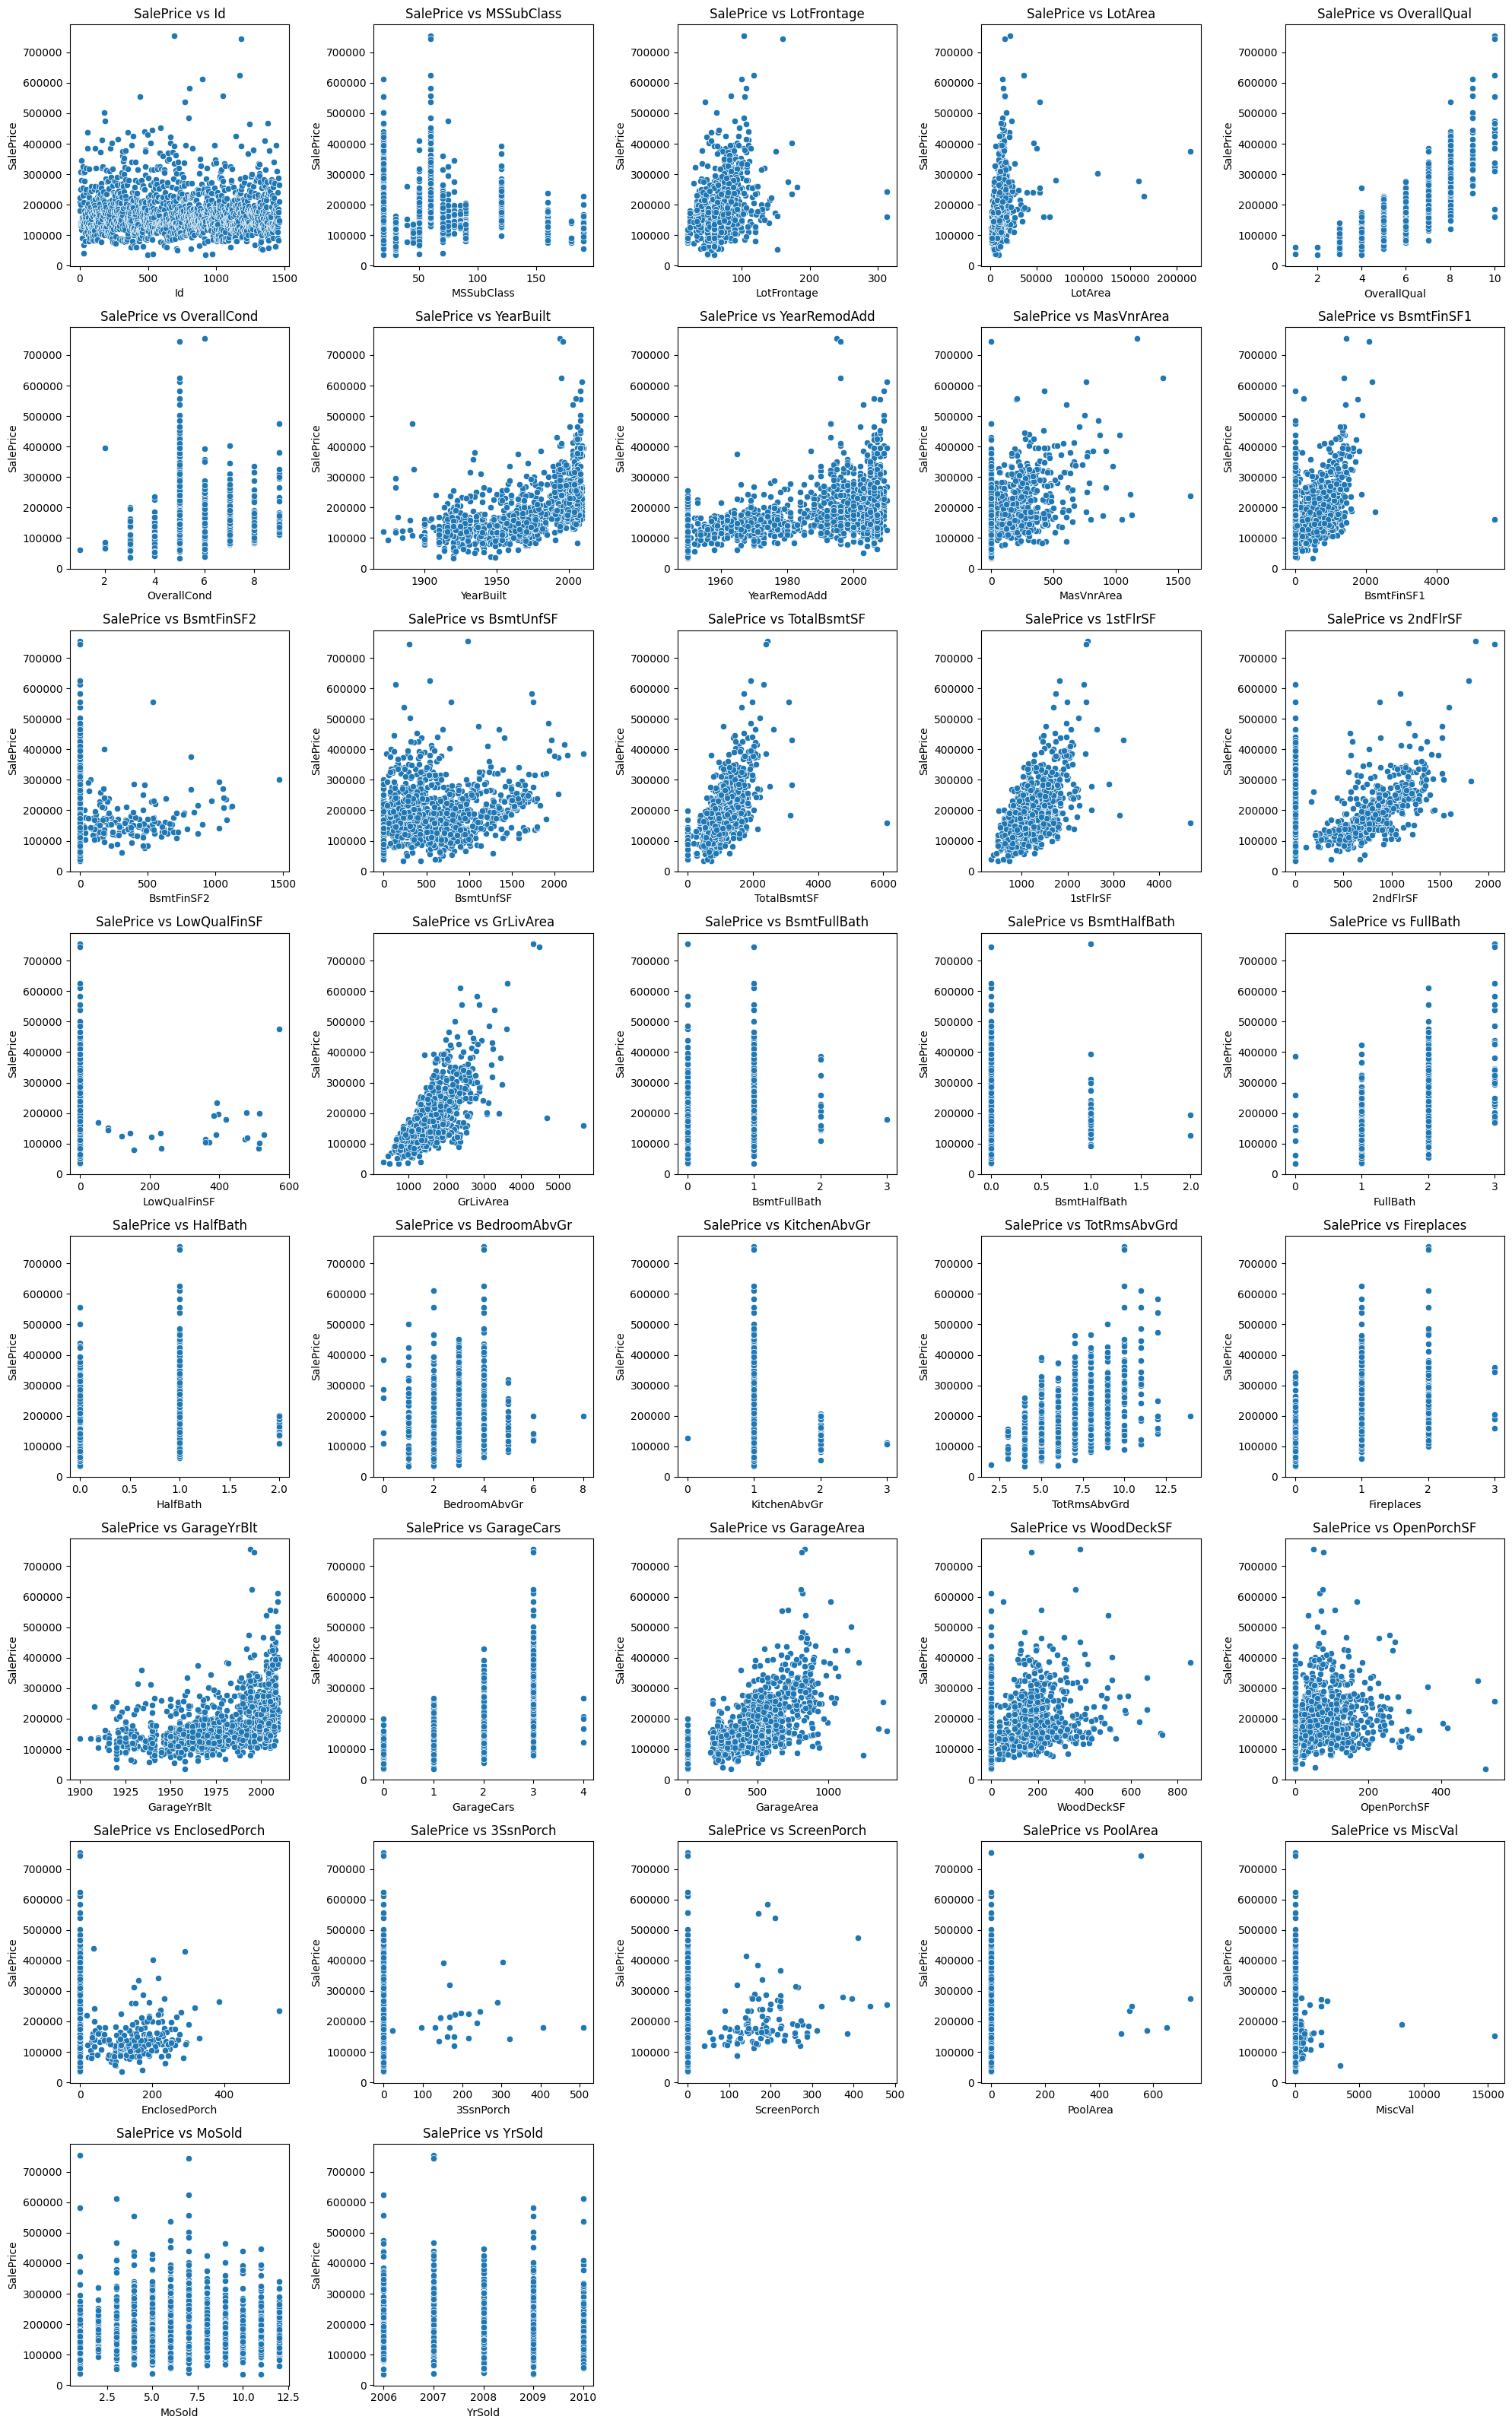

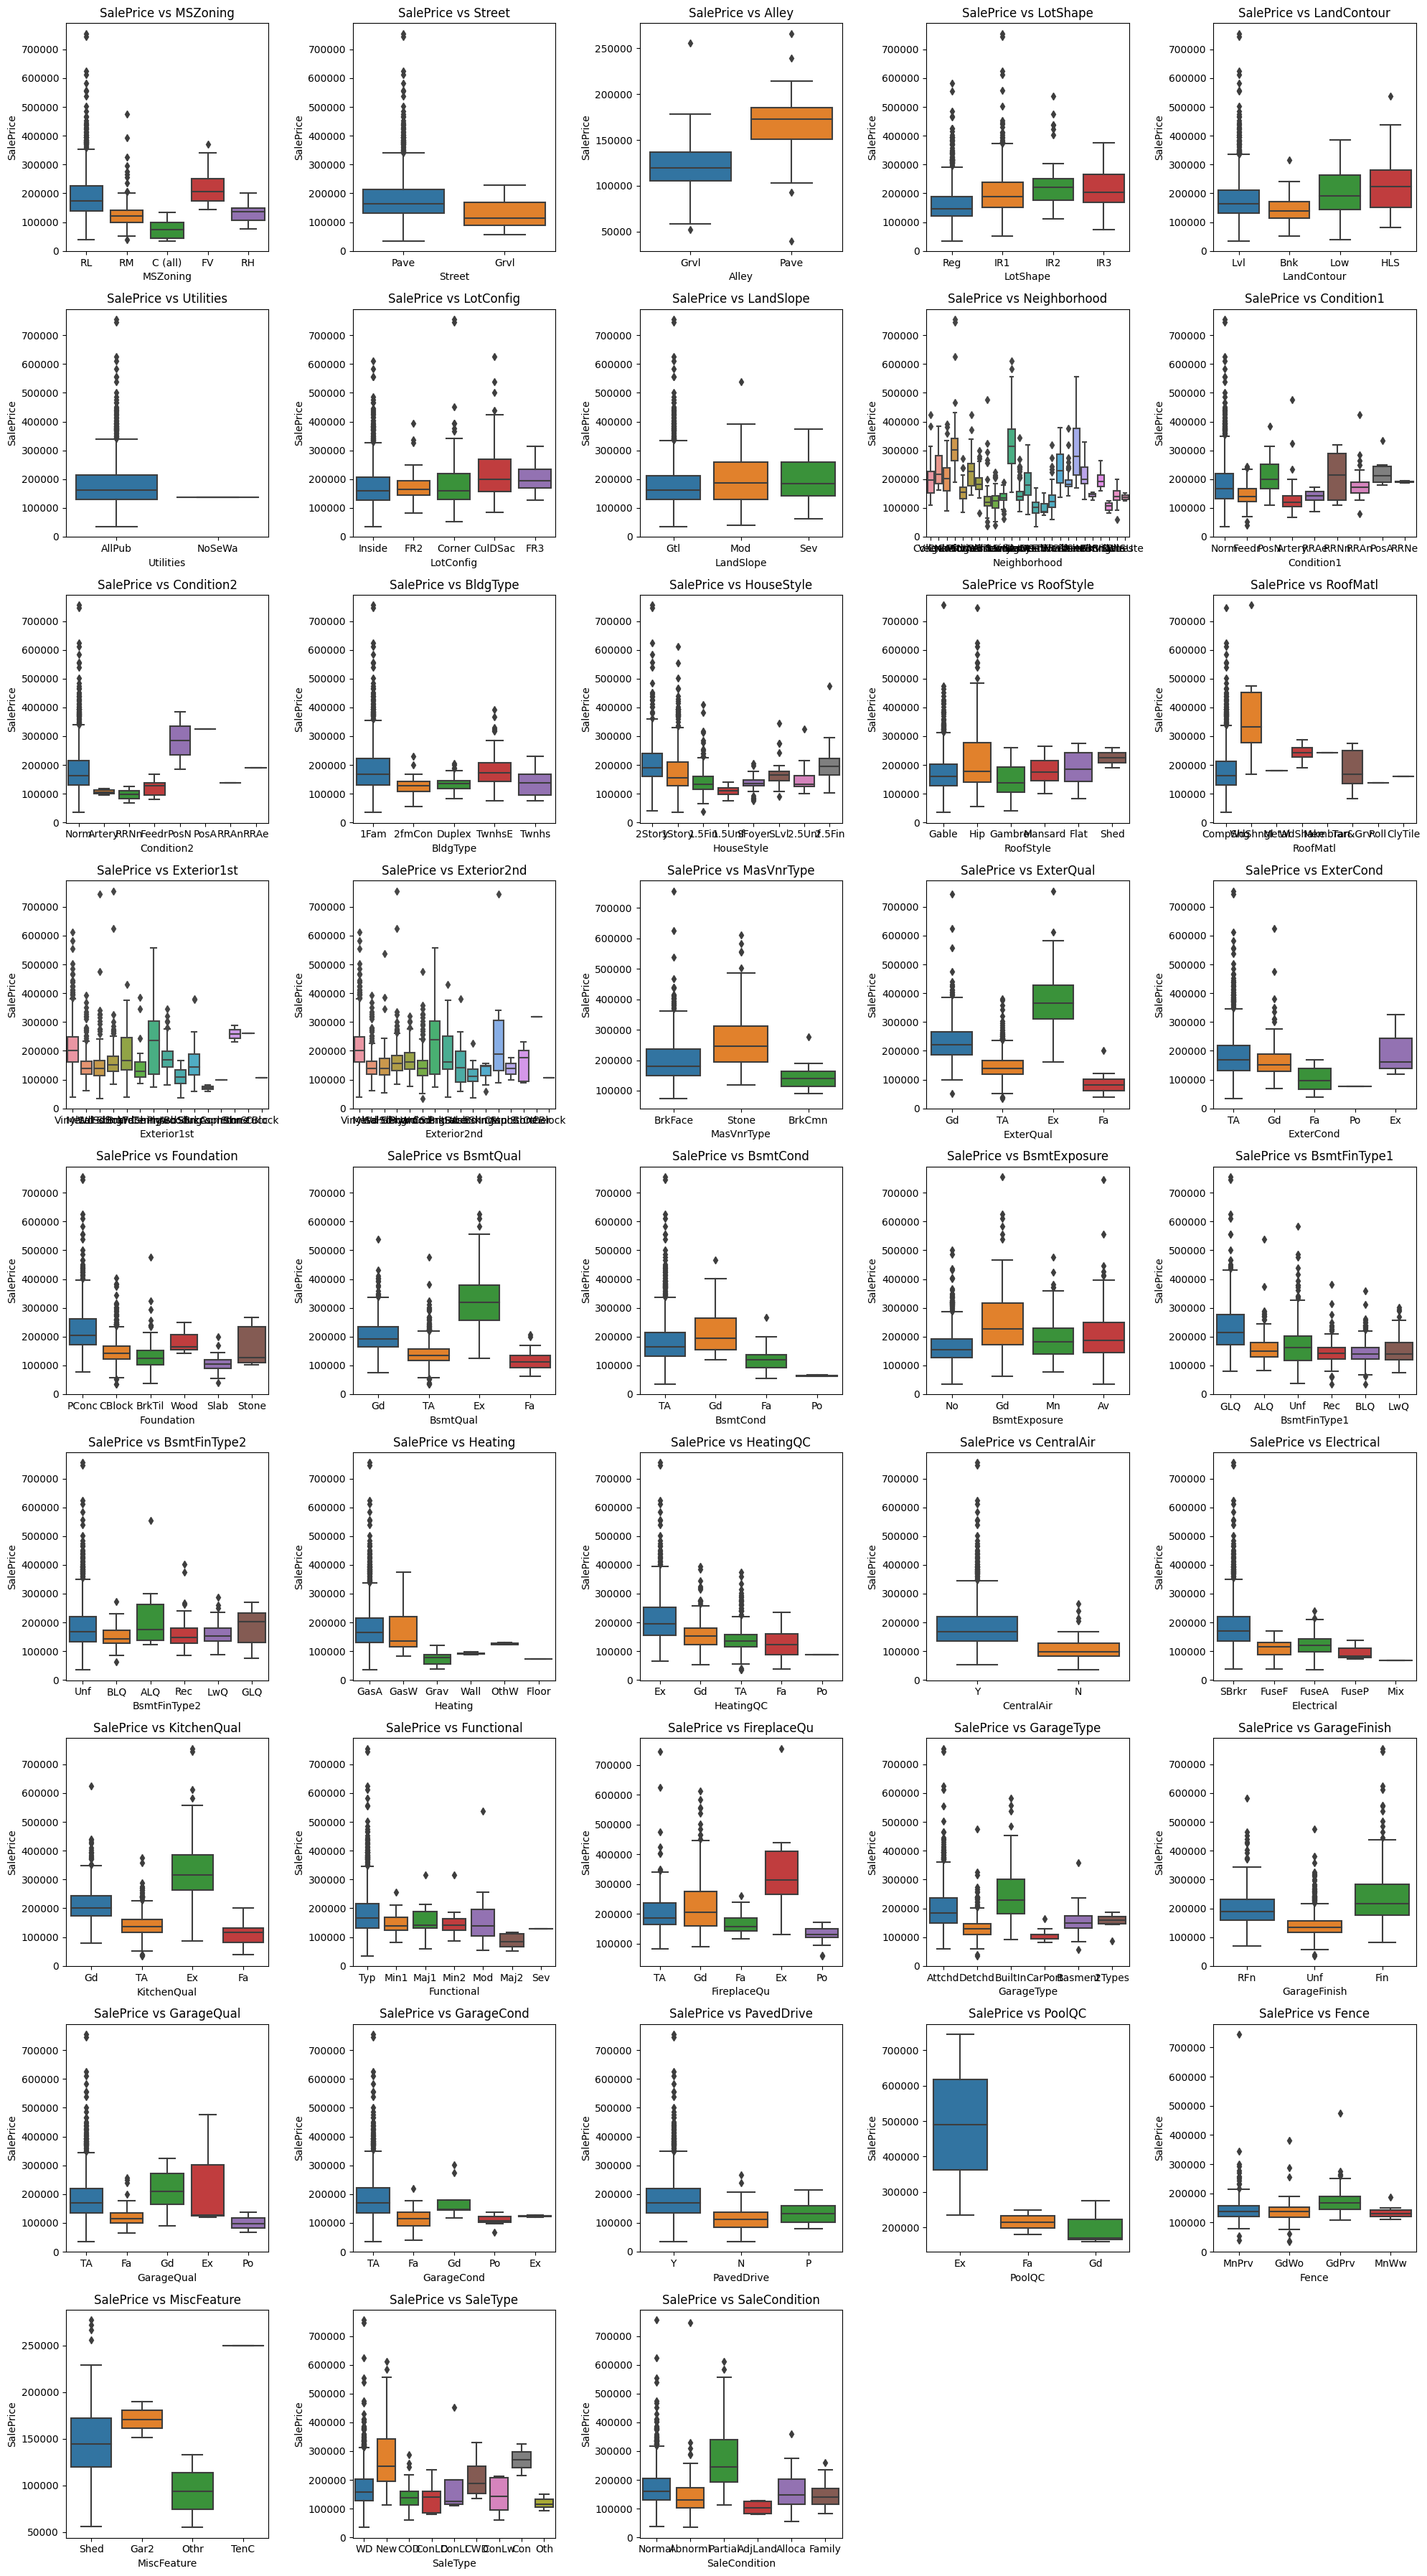

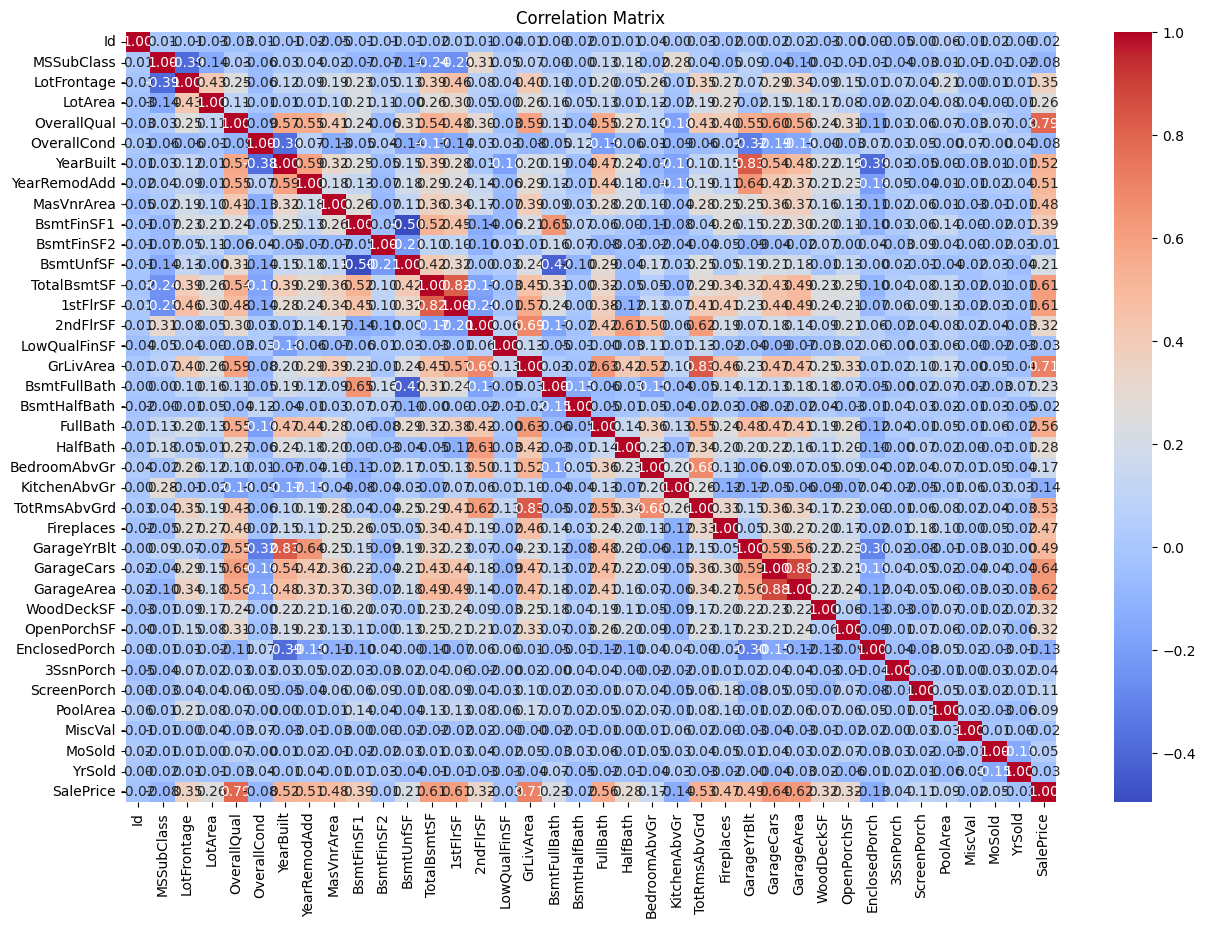

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming houses_cleaned is already loaded and cleaned
# Let's create synthetic examples for visualization based on your request

# 1. Histograms for each numeric feature, 5 per row
numeric_cols = houses_cleaned.select_dtypes(include=[np.number]).columns
n_cols = 5
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(20, 4 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(houses_cleaned[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

# 2. Scatter plots for 'SalePrice' vs each numeric feature, 5 per row
# Excluding 'SalePrice' itself from the comparison
comparison_cols = [col for col in numeric_cols if col != 'SalePrice']

plt.figure(figsize=(20, 4 * n_rows))
for i, col in enumerate(comparison_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=houses_cleaned, x=col, y='SalePrice')
    plt.title(f'SalePrice vs {col}')
plt.tight_layout()
plt.show()

# 3. Box plots for 'SalePrice' vs each categorical feature, 5 per row
categorical_cols = houses_cleaned.select_dtypes(exclude=[np.number]).columns
n_rows_cat = int(np.ceil(len(categorical_cols) / n_cols))

plt.figure(figsize=(20, 4 * n_rows_cat))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows_cat, n_cols, i)
    sns.boxplot(x=col, y='SalePrice', data=houses_cleaned)
    plt.title(f'SalePrice vs {col}')
plt.tight_layout()
plt.show()

# 4. Correlation matrix excluding non-numeric columns
plt.figure(figsize=(15, 10))
corr_matrix = houses_cleaned.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [7]:
houses.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
import scipy.stats as stats
import pandas as pd
import numpy as np

# Assuming houses_cleaned is your DataFrame
categorical_cols = houses_cleaned.select_dtypes(exclude=[np.number]).columns

# Initialize a dictionary to hold summary statistics and test results for each category
category_analysis = {}

for category in categorical_cols:
    categories = houses_cleaned[category].dropna().unique()
    medians = {}
    iqr_values = {}
    non_empty_groups = []

    for cat in categories:
        group = houses_cleaned[houses_cleaned[category] == cat]['SalePrice'].dropna()
        
        if not group.empty:
            medians[cat] = np.median(group)
            Q1 = np.percentile(group, 25)
            Q3 = np.percentile(group, 75)
            iqr_values[cat] = Q3 - Q1
            non_empty_groups.append(group)
            
    # Only proceed with the Kruskal-Wallis test if there are at least two non-empty groups
    if len(non_empty_groups) > 1:
        stat, p = stats.kruskal(*non_empty_groups)
        test_result = f"Stat={stat}, p={p}"
    else:
        test_result = "Insufficient data for Kruskal-Wallis Test."
    
    # Store the results
    category_analysis[category] = {
        'Medians': medians,
        'IQRs': iqr_values,
        'Kruskal-Wallis Test': test_result
    }

# Print the analysis results
for category, results in category_analysis.items():
    print(f"\nCategory: {category}")
    print("Medians:", results['Medians'])
    print("IQRs:", results['IQRs'])
    print("Kruskal-Wallis Test:", results['Kruskal-Wallis Test'])


Category: MSZoning
Medians: {'RL': 174000.0, 'RM': 120500.0, 'C (all)': 74700.0, 'FV': 205950.0, 'RH': 136500.0}
IQRs: {'RL': 87000.0, 'RM': 40000.0, 'C (all)': 54333.75, 'FV': 76000.0, 'RH': 42458.5}
Kruskal-Wallis Test: Stat=270.0701971937021, p=3.0807239995999556e-57

Category: Street
Medians: {'Pave': 163000.0, 'Grvl': 114250.0}
IQRs: {'Pave': 84000.0, 'Grvl': 81400.0}
Kruskal-Wallis Test: Stat=3.0623530770349503, p=0.08012555757743882

Category: Alley
Medians: {'Grvl': 119500.0, 'Pave': 172500.0}
IQRs: {'Grvl': 31437.5, 'Pave': 34000.0}
Kruskal-Wallis Test: Stat=32.53042103564089, p=1.1734131508207314e-08

Category: LotShape
Medians: {'Reg': 146000.0, 'IR1': 189000.0, 'IR2': 221000.0, 'IR3': 203570.0}
IQRs: {'Reg': 68000.0, 'IR1': 89000.0, 'IR2': 75000.0, 'IR3': 97125.0}
Kruskal-Wallis Test: Stat=150.9541727114465, p=1.6403232738441862e-32

Category: LandContour
Medians: {'Lvl': 162900.0, 'Bnk': 139400.0, 'Low': 190000.0, 'HLS': 222250.0}
IQRs: {'Lvl': 82000.0, 'Bnk': 58250.0, 'L

# Data Preprocessing and Pipeline

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define numerical and categorical features
# numerical_features = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
#                       'TotalBsmtSF', 'GrLivArea', 'FullBath', 'Fireplaces', 'GarageCars']

# categorical_features = ['CentralAir', 'KitchenQual', 'ExterQual']
# We want to improve our score by removing some of the features 

# Define numerical and categorical features
numerical_features = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea','TotalBsmtSF', 'GrLivArea', 'FullBath', 'Fireplaces', 'GarageCars']

categorical_features = ['CentralAir', 'KitchenQual', 'ExterQual']


# Create pipelines for both numerical and categorical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='none')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines with a ColumnTransformer
full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Now you can fit this pipeline to your data and then transform it
X_train = full_pipeline.fit(houses)


In [10]:
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

X = houses[categorical_features + numerical_features]  # Adjust 'TargetColumn' to the actual name of your target variable
y = houses['SalePrice']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming `full_pipeline` is your preprocessing pipeline from the previous example
# Apply the preprocessing pipeline to the training data and then to the test data
X_train_preprocessed = full_pipeline.fit_transform(X_train)
X_test_preprocessed = full_pipeline.transform(X_test)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGB": XGBRegressor(objective='reg:squarederror', random_state=42),
    "Bagging": BaggingRegressor(n_estimators=10, random_state=42),
    #"Neural Network": MLPRegressor(random_state=42, max_iter=500),
    "LGBM": LGBMRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)  # Ensure to use preprocessed data
    predictions = model.predict(X_test_preprocessed)  # Ensure to use preprocessed data
    rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(predictions)))
    print(f"{name} RMSE: {rmse}")
# Since preprocessing is done, fit and evaluate models directly
    mae = mean_absolute_error(y_test, predictions)
    print(f"{name} MAE: {mae}")

# Ensemble
ensemble_models = [(name, Pipeline(steps=[('preprocessor', full_pipeline), (name, model)])) for name, model in models.items()]
ensemble = VotingRegressor(estimators=ensemble_models)
ensemble.fit(X_train, y_train)
ensemble_predictions = ensemble.predict(X_test)
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
print(f"Ensemble MAE: {ensemble_mae}")

Linear Regression RMSE: 0.18119608468888979
Linear Regression MAE: 23387.02397260274
Random Forest RMSE: 0.16221834483236922
Random Forest MAE: 18752.401105675144
XGB RMSE: 0.1831750849947414
XGB MAE: 21293.99360552226
Bagging RMSE: 0.1667265967269941
Bagging MAE: 19500.545613176775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 18
[LightGBM] [Info] Start training from score 181441.541952
LGBM RMSE: 0.1650735623544885
LGBM MAE: 19838.305927698835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train 

**Hyperparameter Tuning**

In [11]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid_rf = {'n_estimators': np.arange(50, 300, 50)}

param_grid_xgb = {'n_estimators': np.arange(50, 300, 50)}

grid_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=param_grid_rf,
                       cv=5,
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1)

grid_xgb = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                        param_grid=param_grid_xgb,
                        cv=5,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1)

grid_rf.fit(X_train_preprocessed, y_train)
grid_xgb.fit(X_train_preprocessed, y_train)

best_params_rf = grid_rf.best_params_
best_score_rf = -grid_rf.best_score_

best_params_xgb = grid_xgb.best_params_
best_score_xgb = -grid_xgb.best_score_

print("Best n_estimators for Random Forest:", best_params_rf)
print("Best n_estimators for XGBoost:", best_params_xgb)



Best n_estimators for Random Forest: {'n_estimators': 250}
Best n_estimators for XGBoost: {'n_estimators': 50}


# Model Selection

# Evaluation

# Submission